# Transfer Learning with TensorFlow Part 2: Fine Tuning

In the previous notebook, we covered transfer learning *feature extraction*, now it's time to learn about a new kind of transfer learning: *fine-tuning*

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions; however, this is tedious.

It's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere)

In [10]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food)

In [7]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test

In [3]:
# Create training and test directories path
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

**Note**: Rather than using the `ImageGenerator` function, we are going to use `tf.keras.preprocessing.image_dataset_from_directory`. This is due to its functionality as a TensorFlow datatype in addition to its speed attributes.

In [4]:
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode="categorical",
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
# Let's look at the dataset
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[ 36.07143     35.07143     51.07143   ]
   [ 32.59694     31.59694     49.59694   ]
   [ 35.438774    32.438774    53.438774  ]
   ...
   [145.01532    113.87238    115.0051    ]
   [150.14804    114.387825   119.45925   ]
   [154.33145    114.97431    121.04574   ]]

  [[ 32.55102     31.55102     47.55102   ]
   [ 34.785713    33.785713    51.785713  ]
   [ 35.285713    32.285713    53.285713  ]
   ...
   [139.04083    108.48467    105.341835  ]
   [139.28572    105.28573    103.500015  ]
   [147.65833    111.658325   111.801186  ]]

  [[ 28.948978    27.948978    43.94898   ]
   [ 27.80102     26.80102     42.801018  ]
   [ 25.95408     22.95408     41.52551   ]
   ...
   [137.71428    107.974464    99.49998   ]
   [145.14275    112.78561    105.015175  ]
   [132.09183     99.73469     91.45402   ]]

  ...

  [[  2.6429005    9.071428     0.28061998]
   [  8.913334    17.000046     0.        ]
   [ 38.64763     49.6731      11.673163  ]
   ...
   [ 31.857056    13.979

## Model 0: Building a transfer learning feature extraction model using the Keras Function API

The `Sequential` API is straight-forward, it runs our layers in sequential order. 

But the functional API gives us more flexibility with our models.

In [11]:
# 1. Create base model with tf.keras.applications
base_model=tf.keras.applications.EfficientNetB0(include_top=False) # include_top is false because we need it to match the number of classes for our problem

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable=False

# 3. Create inputs 
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize input (you don't have to for EfficientNet(s))
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x=base_model(inputs)
print(f"Shape after passing inputs through base model:{x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important info, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the otuputs into a model
model_0=tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="10_percent_feature_extraction")]) # only validating on 25% of the data

Shape after passing inputs through base model:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220822-144055
Epoch 1/5
24/24 [==============================] - 19s 355ms/step - loss: 1.8500 - accuracy: 0.4493 - val_loss: 1.2646 - val_accuracy: 0.7533
Epoch 2/5
24/24 [==============================] - 6s 257ms/step - loss: 1.0974 - accuracy: 0.7800 - val_loss: 0.8516 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 6s 257ms/step - loss: 0.7903 - accuracy: 0.8307 - val_loss: 0.6710 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 6s 256ms/step - loss: 0.6390 - accuracy: 0.8613 - val_loss: 0.6167 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 6s 257ms/step - loss: 0.5388 - accuracy: 0.8893 - val_loss: 0.5370 - val_accuracy: 0.8701


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 11s 142ms/step - loss: 0.5548 - accuracy: 0.8648


[0.5548474788665771, 0.864799976348877]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 tf.math.truediv_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [14]:
# Summary of base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


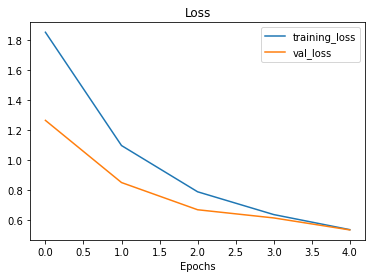

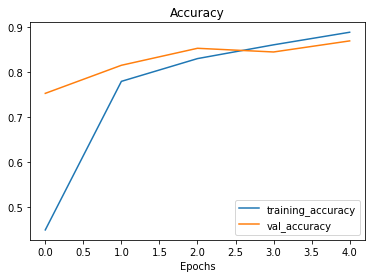

In [16]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

### Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D Layer ... 

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280) ...

But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to `GlobalAveragePooling2D`

In [19]:
# Define the input shape 
input_shape=(1,4,4,3) # Count backwards ("sheets",matrices,rows,columns)

# Create random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

# Check the shape of the different tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [20]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>